[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moaid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moaid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\moaid\AppData\Local\Temp\ipykernel_16016\2265932069.py:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Category'] = df['Category'].replace({'spam': 1, 'ham': 0}).astype(int)


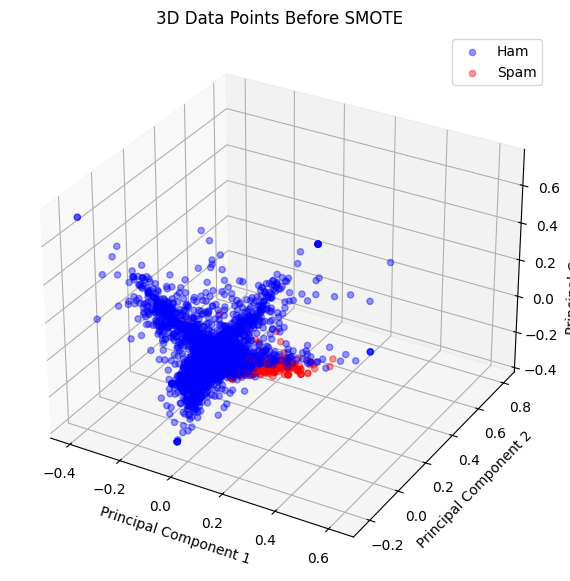

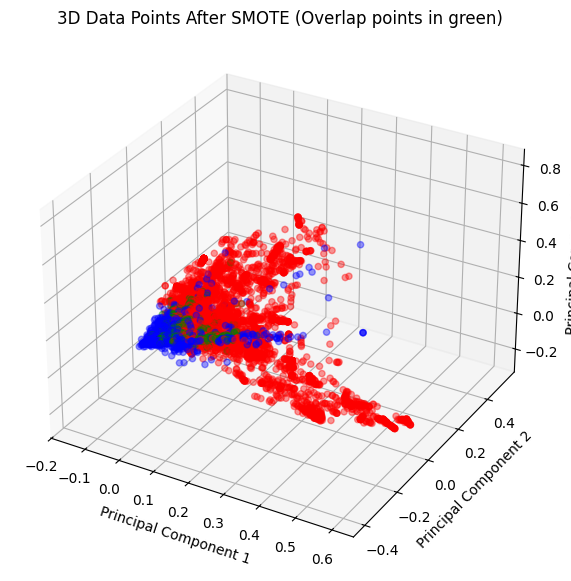

Bag of words saved to bag_of_words.csv


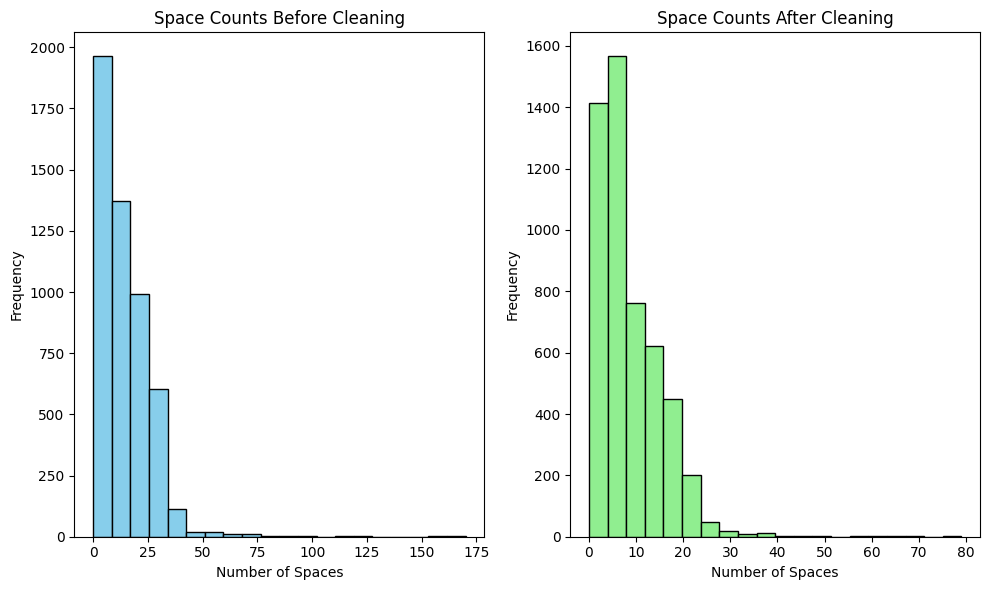

Cleaned data saved to cleaneddata.csv
   Category                                           Masseges  \
0         0  Go until jurong point, crazy.. Available only ...   
1         0                      Ok lar... Joking wif u oni...   
2         1  Free entry in 2 a wkly comp to win FA Cup fina...   
3         0  U dun say so early hor... U c already then say...   
4         0  Nah I don't think he goes to usf, he lives aro...   

                                    Cleaned_Masseges  Space_Count_Before  \
0  go jurong point crazy available bugis n great ...                  19   
1                            ok lar joking wif u oni                   5   
2  free entry two wkly comp win fa cup final tkts...                  27   
3                u dun say early hor u c already say                  10   
4        nah dont think goes usf lives around though                  12   

   Space_Count_After  
0                 15  
1                  5  
2                 22  
3               

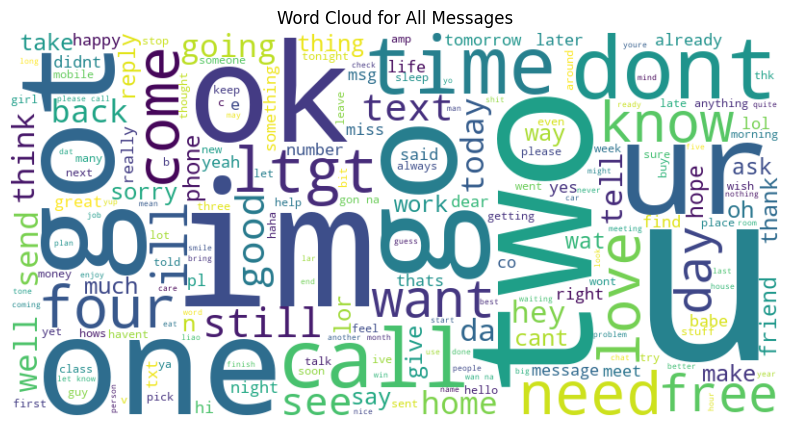

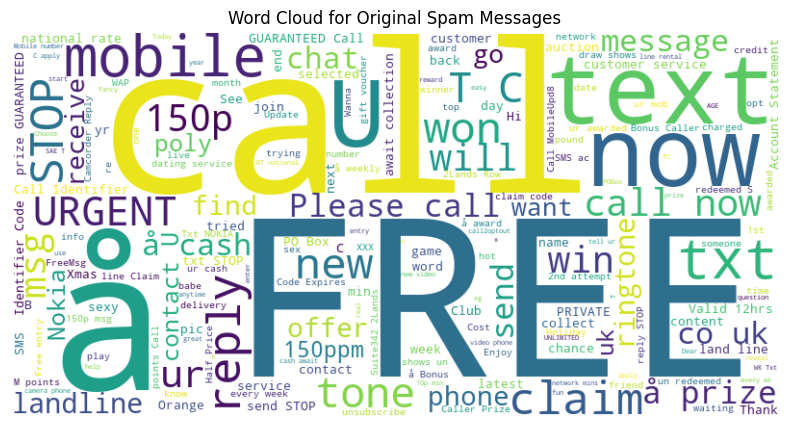

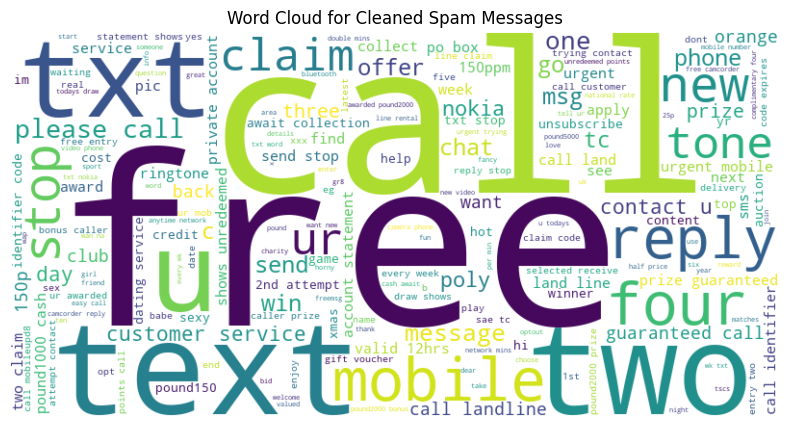

Cleaned spam messages saved to cleaned_spam_messages.csv


In [6]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

class TextCleaner:
    def __init__(self, text):
        self.text = text.lower()
        self.space_count = 0
        self.extra_spaces_count = 0

    def replace_urls(self):
        self.text = re.sub(r'http\S+|www\S+|https\S+', 'URL', self.text)

    def replace_money_symbols(self):
        self.text = re.sub(r'[$€£¥₹]', lambda x: {'$':'dollar', '€':'euro', '£':'pound', '¥':'yen', '₹':'rupee'}[x.group()], self.text)

    def replace_digits_with_text_numbers(self):
        num_dict = {
            '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
            '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'
        }
        for digit, word in num_dict.items():
            self.text = re.sub(fr'\b{digit}\b', word, self.text)

    def remove_non_alphanumeric(self):
        self.text = re.sub(r'[^a-z0-9\s]', '', self.text)

    def count_spaces(self):
        self.space_count = self.text.count(' ')

    def count_extra_spaces(self):
        original_spaces = len(re.findall(r' ', self.text))
        self.text = re.sub(r'\s+', ' ', self.text).strip()
        cleaned_spaces = len(re.findall(r' ', self.text))
        self.extra_spaces_count = original_spaces - cleaned_spaces

    def remove_extra_spaces(self):
        self.text = re.sub(r'\s+', ' ', self.text).strip()

    def remove_stop_words(self):
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(self.text)
        self.text = ' '.join([word for word in word_tokens if word not in stop_words])

    def clean(self):
        self.replace_urls()
        self.replace_money_symbols()
        self.replace_digits_with_text_numbers()
        self.remove_non_alphanumeric()
        self.count_spaces()
        self.count_extra_spaces()
        self.remove_extra_spaces()
        self.remove_stop_words()
        return self.text

def get_word_frequencies(texts):
    """ Returns word frequencies from a list of cleaned text messages. """
    all_words = ' '.join(texts).split()
    return Counter(all_words)

# Function to detect overlapping points and color them green
def detect_overlaps_and_color(X, y, threshold=0.01):
    colors = []
    for i in range(len(X)):
        overlap = False
        for j in range(i + 1, len(X)):
            dist = np.linalg.norm(X[i] - X[j])
            if dist < threshold and y[i] != y[j]:  # If distance is below threshold and they belong to different classes
                overlap = True
                break
        if overlap:
            colors.append('green')
        elif y[i] == 0:
            colors.append('blue')  # Ham
        else:
            colors.append('red')  # Spam
    return colors

try:
    df = pd.read_csv('spammail.csv')

    # Handling Missing Values
    df.dropna(subset=['Masseges'], inplace=True)

    # Replace 'spam' with 1 and 'ham' with 0, then explicitly convert to integers
    df['Category'] = df['Category'].replace({'spam': 1, 'ham': 0}).astype(int)

    # Apply text cleaning
    cleaned_messages = []
    space_counts_before = []
    space_counts_after = []

    for message in df['Masseges']:
        cleaner = TextCleaner(message)
        cleaner.count_spaces()
        space_counts_before.append(cleaner.space_count)
        cleaned_text = cleaner.clean()
        cleaner.count_spaces()
        space_counts_after.append(cleaner.space_count)
        cleaned_messages.append(cleaned_text)

    df['Cleaned_Masseges'] = cleaned_messages
    df['Space_Count_Before'] = space_counts_before
    df['Space_Count_After'] = space_counts_after

    # Handling Duplicates
    df.drop_duplicates(subset=['Cleaned_Masseges'], inplace=True)
    
    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['Cleaned_Masseges']).toarray()
    y = df['Category'].values

    # Visualizing data points before balancing using 3D PCA
    pca = PCA(n_components=3)
    X_pca_before = pca.fit_transform(X)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca_before[y == 0, 0], X_pca_before[y == 0, 1], X_pca_before[y == 0, 2], label='Ham', alpha=0.4, c='blue')
    ax.scatter(X_pca_before[y == 1, 0], X_pca_before[y == 1, 1], X_pca_before[y == 1, 2], label='Spam', alpha=0.4, c='red')

    ax.set_title('3D Data Points Before SMOTE')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Modify the 3D scatter plot to include green for overlapping points
    X_pca_after = pca.fit_transform(X_resampled)
    colors = detect_overlaps_and_color(X_pca_after, y_resampled, threshold=0.01)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca_after[:, 0], X_pca_after[:, 1], X_pca_after[:, 2], c=colors, alpha=0.4)

    ax.set_title('3D Data Points After SMOTE (Overlap points in green)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

    # Bag of Words Creation for all messages
    all_messages = df['Cleaned_Masseges']
    word_freq = get_word_frequencies(all_messages)

    bag_of_words = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    bag_of_words_file_path = 'bag_of_words.csv'
    bag_of_words.to_csv(bag_of_words_file_path, index=False)

    print(f"Bag of words saved to {bag_of_words_file_path}")
    
    # Plot space counts
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df['Space_Count_Before'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Space Counts Before Cleaning')
    plt.xlabel('Number of Spaces')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(df['Space_Count_After'], bins=20, color='lightgreen', edgecolor='black')
    plt.title('Space Counts After Cleaning')
    plt.xlabel('Number of Spaces')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Save the cleaned data to a new CSV file
    cleaned_file_path = 'cleaneddata.csv'
    df.to_csv(cleaned_file_path, index=False)

    print(f"Cleaned data saved to {cleaned_file_path}")
    print(df.head())

    # Create and display a word cloud for all cleaned messages
    all_text = ' '.join(df['Cleaned_Masseges'])
    wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_all, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for All Messages')
    plt.show()

    # Create and display word clouds for original (uncleaned) spam messages
    original_spam_messages = df[df['Category'] == 1]['Masseges']
    original_spam_text = ' '.join(original_spam_messages)
    wordcloud_original_spam = WordCloud(width=800, height=400, background_color='white').generate(original_spam_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_original_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Original Spam Messages')
    plt.show()

    # Create and display word clouds for cleaned spam messages
    cleaned_spam_messages = df[df['Category'] == 1]['Cleaned_Masseges']
    cleaned_spam_text = ' '.join(cleaned_spam_messages)
    wordcloud_cleaned_spam = WordCloud(width=800, height=400, background_color='white').generate(cleaned_spam_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_cleaned_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Cleaned Spam Messages')
    plt.show()

    # Save cleaned spam messages to a new CSV file
    cleaned_spam_file_path = 'cleaned_spam_messages.csv'
    cleaned_spam_messages.to_csv(cleaned_spam_file_path, index=False, header=['Cleaned_Spam_Messages'])

    print(f"Cleaned spam messages saved to {cleaned_spam_file_path}")

except Exception as e:
    print(f"An error occurred: {e}")
